In [1]:
import collections
import json
import os
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model
import re
from tqdm import tqdm
import pandas as pd
import warnings
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, TimeDistributed
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from keras.utils import to_categorical

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [8, 4]
warnings.filterwarnings("ignore", category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


In [2]:
from zipfile import ZipFile

file_name = "scifi-stories-text-corpus.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


## Dataset Overview

In [0]:
data_path = "internet_archive_scifi_v3.txt"

In [0]:
with tf.gfile.GFile(data_path, 'r') as f:
        data = f.read()

In [4]:
print(type(data))
print(len(data))

<class 'str'>
149326361


In [5]:
print(data[:200])

MARCH # All Stories New and Complete Publisher Editor IF is published bi-monthly by Quinn Publishing Company, Inc., Kingston, New York. Volume #, No. #. Copyright # by Quinn Publishing Company, Inc. A


## Data Pre-Processing

In [6]:
processed_data = ""

for word in tqdm(data.split(" ")):
  word = word.lower()
  word1 = word.replace("wouldn't","would not").replace("don't","do not").replace("what's","what is").replace("doesn't","does not")
  if(word1!=word):
    processed_data+=" "+word1
  else:
    word = re.sub("[^a-zA-Z]+", "", word)
    if(word.isalnum()):
      processed_data+=" "+word

100%|██████████| 26655101/26655101 [01:06<00:00, 397913.59it/s]


In [7]:
print("BEFORE PROCESSING:")
print(data[:200])
print()
print("AFTER PROCESSING:")
print(processed_data[:200])

BEFORE PROCESSING:
MARCH # All Stories New and Complete Publisher Editor IF is published bi-monthly by Quinn Publishing Company, Inc., Kingston, New York. Volume #, No. #. Copyright # by Quinn Publishing Company, Inc. A

AFTER PROCESSING:
 march all stories new and complete publisher editor if is published bimonthly by quinn publishing company inc kingston new york volume no copyright by quinn publishing company inc application for ent


In [0]:
processed_data = processed_data[7:]

## Data Analysis:

In [0]:
processed_data = processed_data[:500000]

In [0]:
processed_data1 = processed_data.split(" ")
counter = (pd.Series(processed_data1)).value_counts()

In [11]:
counter[:10]

the    5237
and    2379
a      2342
to     2306
of     2177
it     1412
i      1303
in     1259
he     1249
you    1195
dtype: int64

In [12]:
print("Total length of data:",len(processed_data))
print("Total number of words in data:",len(processed_data.split(" ")))
print("Total number of unique words :",len(counter))

Total length of data: 500000
Total number of words in data: 94312
Total number of unique words : 10427


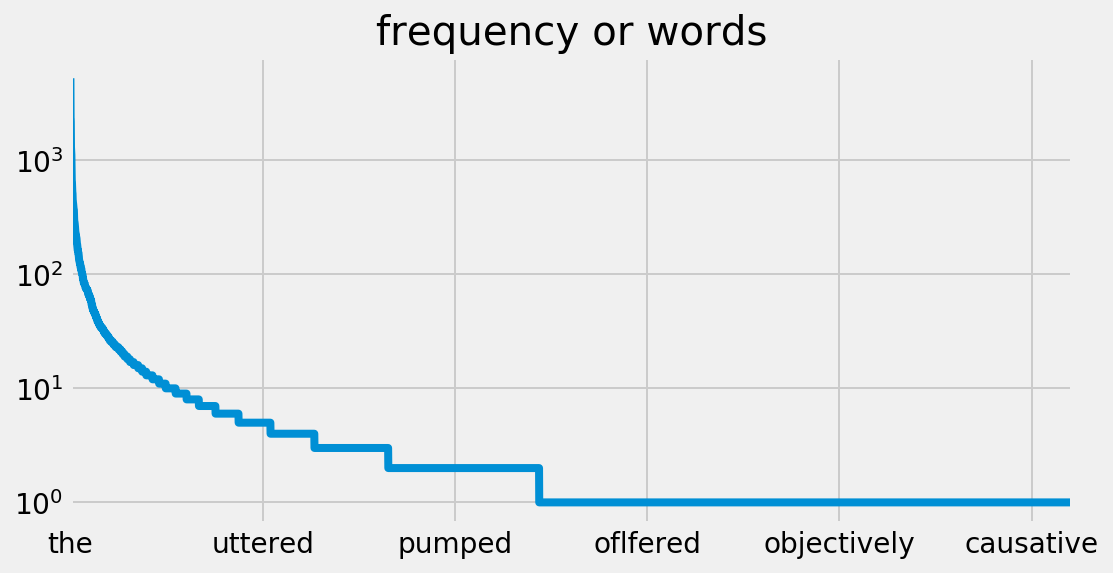

In [13]:
counter.plot(kind="line", logy=True, title="frequency or words")

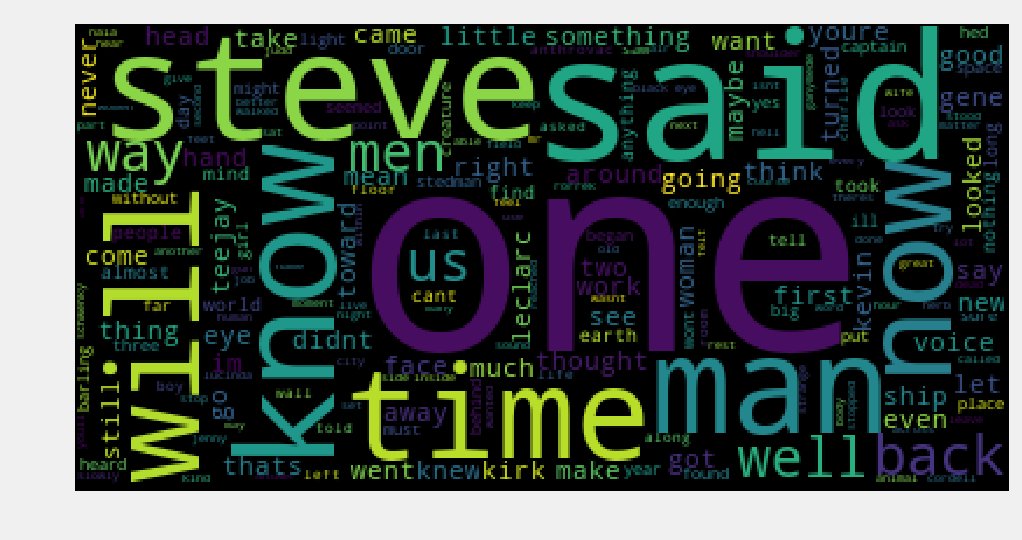

In [14]:
wordcloud2 = WordCloud().generate(processed_data)

plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

## Preparation Training Data

In [0]:
number_of_words = 3
list_processed_data = processed_data.split(" ")
total_num_of_words = len(list_processed_data)
X=[]; y=[]

In [14]:
for i in tqdm(range(number_of_words,total_num_of_words)):
  sent = []
  for j in range(i-number_of_words,i):
    sent.append(list_processed_data[j])
  X.append(sent)
  y.append(list_processed_data[i])
  

100%|██████████| 94309/94309 [00:00<00:00, 301814.59it/s]


In [15]:
print("Original Dataset 1st 15 words: ",processed_data[:100])

Original Dataset 1st 15 words:  all stories new and complete publisher editor if is published bimonthly by quinn publishing company 


In [16]:
print("\tTRAIN DATA","\t\t NEXT WORD (ground truth)")
[ print(X[i], " -->  ", y[i]) for i in range(10) ]

	TRAIN DATA 		 NEXT WORD (ground truth)
['all', 'stories', 'new']  -->   and
['stories', 'new', 'and']  -->   complete
['new', 'and', 'complete']  -->   publisher
['and', 'complete', 'publisher']  -->   editor
['complete', 'publisher', 'editor']  -->   if
['publisher', 'editor', 'if']  -->   is
['editor', 'if', 'is']  -->   published
['if', 'is', 'published']  -->   bimonthly
['is', 'published', 'bimonthly']  -->   by
['published', 'bimonthly', 'by']  -->   quinn


[None, None, None, None, None, None, None, None, None, None]

In [17]:
print("Training data shape: ",(len(X),len(X[0])))
print("Ouput data shape:",(len(y),1))

Training data shape:  (94309, 3)
Ouput data shape: (94309, 1)


### Train Validation spilt

In [0]:
X_train = X[:75000]
X_val = X[75000:]
y_train = y[:75000]
y_val = y[75000:]

### convert word to id for all words in vocabulary

In [0]:
def build_vocab(data):
  
    counter = collections.Counter(data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))

    return word_to_id

In [0]:
def file_to_word_ids(data, word_to_id):
  data_id = []
  for sent in data:
    sent_id = [word_to_id[word] for word in sent if word in word_to_id]
    data.append(sent_id)
  return data

In [0]:
word_to_id = build_vocab(list_processed_data)

In [22]:
print("Number of unique words having (word:id) pairs:",len(word_to_id))

Number of unique words having (word:id) pairs: 10427


In [23]:
train_data = []

for i,sent in tqdm(enumerate(X_train)):
  sent_id = [word_to_id[word] for word in sent if word in word_to_id]
  train_data.append(sent_id)

75000it [00:00, 282091.64it/s]


In [24]:
valid_data = []

for i,sent in tqdm(enumerate(X_val)):
  sent_id = [word_to_id[word] for word in sent if word in word_to_id]
  valid_data.append(sent_id)

19309it [00:00, 543214.27it/s]


In [0]:
y_train_data = [word_to_id[word] for word in y_train if word in word_to_id]
y_val_data = [word_to_id[word] for word in y_val if word in word_to_id]

### Example

In [26]:
print(" TRAIN DATA","\t NEXT WORD (ground truth)")
[ print(train_data[i], " -->  ", y_train_data[i]) for i in range(10) ]

 TRAIN DATA 	 NEXT WORD (ground truth)
[35, 559, 151]  -->   1
[559, 151, 1]  -->   624
[151, 1, 624]  -->   3058
[1, 624, 3058]  -->   456
[624, 3058, 456]  -->   47
[3058, 456, 47]  -->   19
[456, 47, 19]  -->   1677
[47, 19, 1677]  -->   2595
[19, 1677, 2595]  -->   63
[1677, 2595, 63]  -->   1981


[None, None, None, None, None, None, None, None, None, None]

### Saving (word:key) in form of dictionary

In [0]:
def save_json(dictionary, filename):
    with open(filename, 'w') as fp:
        json.dump(dictionary, fp)

In [0]:
save_json(word_to_id, 'word_to_id.json')

### Save prepared data

In [65]:
df = pd.DataFrame((train_data+valid_data))
df["output"] = y_train_data+y_val_data

print(df.shape)
df.head()

(94309, 4)


,0,1,2,output
0,35,559,151,1
1,559,151,1,624
2,151,1,624,3058
3,1,624,3058,456
4,624,3058,456,47


In [0]:
# save dataframe
df.to_csv("sentence_to_id_text.csv",index=False)

### Loading of Data

In [3]:
data = pd.read_csv("sentence_to_id_text.csv")
print(data.shape)
data.head()

(187781, 4)


,0,1,2,output
0,35,509,173,1
1,509,173,1,718
2,173,1,718,3398
3,1,718,3398,547
4,718,3398,547,42


In [0]:
# word_to_id = load_json('word_to_id.json')

In [5]:
X = []; Y=[]

for i in tqdm(range(data.shape[0])):
  sent = []
  sent.append((data.iloc[i]["0"]))
  sent.append((data.iloc[i]["1"]))
  sent.append((data.iloc[i]["2"]))
  
  X.append(sent)
  Y.append(data.iloc[i]["output"])

100%|██████████| 187781/187781 [02:49<00:00, 1151.85it/s]


In [0]:
train_data = X[:150000]
val_data = X[150000:]
y_train_data = Y[:150000]
y_val_data = Y[150000:]

## Training the Model

In [66]:
y_train = to_categorical(df["output"], num_classes=len(word_to_id))

print(y_train.shape)

(94309, 10427)


In [67]:
df = df.drop("output",axis=1)
X_train = df
print(X_train.shape)

(94309, 3)


In [0]:
vocab_size = len(word_to_id)
max_length = 3

In [0]:
hidden_size = 150
num_epochs = 100

In [73]:
# define model
model = Sequential()

# Embedding layer / Input layer
model.add(Embedding(vocab_size, 10, input_length=max_length))

# 4 LSTM layers
model.add(LSTM(units=hidden_size, return_sequences=True))
model.add(LSTM(units=hidden_size, return_sequences=True))
model.add(LSTM(units=hidden_size, return_sequences=True))
model.add(LSTM(units=hidden_size, return_sequences=False))

# Fully Connected layer
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3, seed=0.2))
model.add(Dense(512, activation='relu'))

# Output Layer
model.add(Dense(vocab_size, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 3, 10)             104270    
_________________________________________________________________
lstm_34 (LSTM)               (None, 3, 150)            96600     
_________________________________________________________________
lstm_35 (LSTM)               (None, 3, 150)            180600    
_________________________________________________________________
lstm_36 (LSTM)               (None, 3, 150)            180600    
_________________________________________________________________
lstm_37 (LSTM)               (None, 150)               180600    
_________________________________________________________________
dense_19 (Dense)             (None, 1024)              154624    
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
__________

In [0]:
# compile network
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [75]:
# fit network
history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32)

Epoch 1/100
94309/94309 [==============================] - 92s 978us/step - loss: 6.9315 - acc: 0.0555
Epoch 2/100
94309/94309 [==============================] - 81s 862us/step - loss: 6.5866 - acc: 0.0648
Epoch 3/100
94309/94309 [==============================] - 82s 870us/step - loss: 6.3580 - acc: 0.0735
Epoch 4/100
94309/94309 [==============================] - 81s 862us/step - loss: 6.1757 - acc: 0.0827
Epoch 5/100
94309/94309 [==============================] - 83s 878us/step - loss: 6.0302 - acc: 0.0895
Epoch 6/100
94309/94309 [==============================] - 81s 862us/step - loss: 5.9027 - acc: 0.0970
Epoch 7/100
94309/94309 [==============================] - 82s 869us/step - loss: 5.7815 - acc: 0.1033
Epoch 8/100
94309/94309 [==============================] - 81s 861us/step - loss: 5.6687 - acc: 0.1080
Epoch 9/100
94309/94309 [==============================] - 82s 868us/step - loss: 5.5630 - acc: 0.1135
Epoch 10/100
94309/94309 [==============================] - 82s 867us/ste

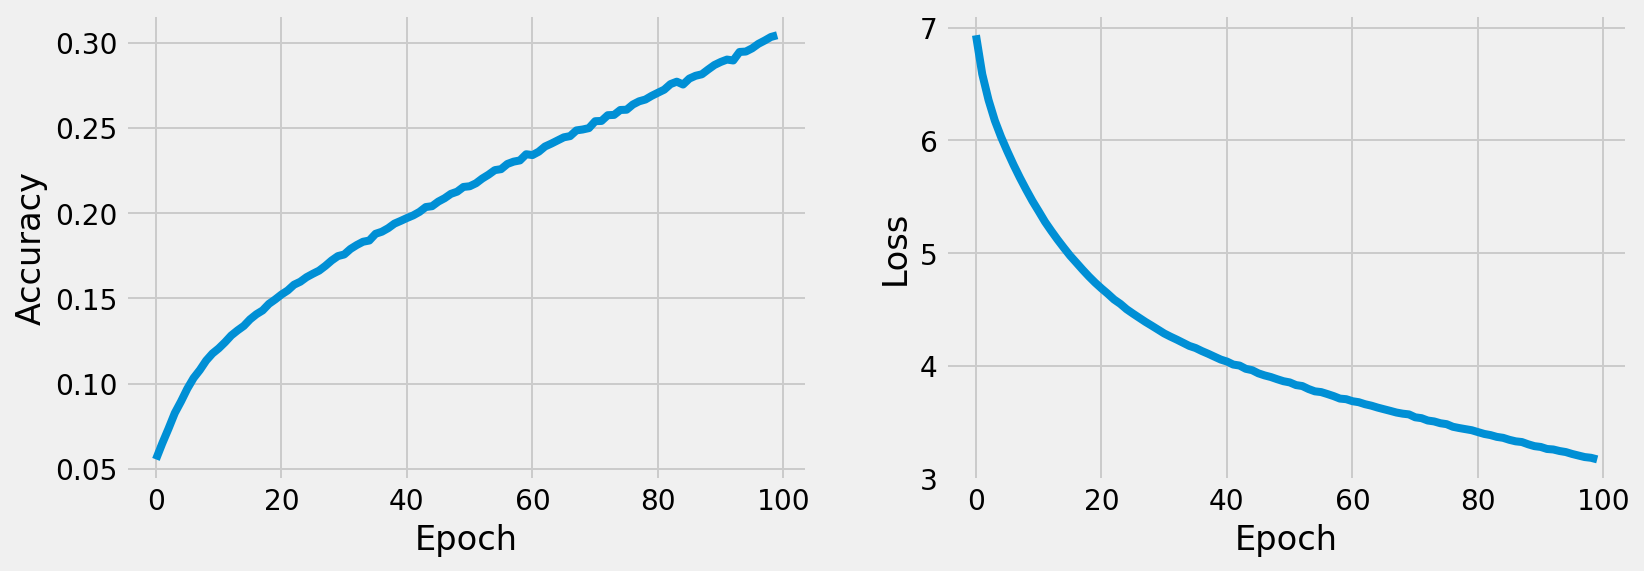

In [83]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Save the keras model

In [85]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## Testing the model

In [110]:
while True:
  sentences = (input('\n\nEnter exactly ' + str(number_of_words) +' words: \n'))
  print('\n')
  if sentences == "BYE":
    print("QUIT !")
    break
  sent_id = np.zeros((1,3))
  for i,word in enumerate(sentences.split(" ")):
    sent_id[0][i] = (word_to_id.get(word))
    
  pred = (model.predict([sent_id]))
  sort_pred = np.sort(pred[0])
  ind = np.argsort(pred[0])
  print("Indexing of input:",sent_id[0])
  print("OUTPUT")
  print("Probability: ",sort_pred[::-1][:5])
  print("Output index",ind[::-1][:5])
  print("Five most probable predicted word:")
  print()
  print([(list(word_to_id.keys())[list(word_to_id.values()).index(out_ind)]) for out_ind in ind[::-1][:5]])
  



Enter exactly 3 words: 
my name is


Indexing of input: [ 51. 279.  19.]
OUTPUT
Probability:  [0.0912922  0.05450968 0.05442028 0.03276524 0.02866372]
Output index [3500    0    2   16   11]
Five most probable predicted word:

['calvin', 'the', 'a', 'not', 'that']


Enter exactly 3 words: 
i reside at


Indexing of input: [6.00e+00 8.84e+03 1.80e+01]
OUTPUT
Probability:  [0.05171013 0.0436397  0.0290166  0.0280817  0.02771386]
Output index [   0 7955 1940 2349  376]
Five most probable predicted word:

['the', 'monroe', 'mild', 'nowhere', 'ann']


Enter exactly 3 words: 
i do not


Indexing of input: [ 6. 23. 16.]
OUTPUT
Probability:  [0.33259043 0.1510726  0.1053549  0.04269391 0.03634592]
Output index [ 59  90 111  64  31]
Five most probable predicted word:

['know', 'think', 'want', 'get', 'have']


Enter exactly 3 words: 
my name is


Indexing of input: [ 51. 279.  19.]
OUTPUT
Probability:  [0.0912922  0.05450968 0.05442028 0.03276524 0.02866372]
Output index [3500    0    2   16 